In [1]:
import  scipy.signal.signaltools
%matplotlib notebook

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import dtscalibration

import os
import warnings

warnings.simplefilter('ignore')  # Hide warnings to avoid clutter in the notebook

from dtscalibration import suggest_cable_shift_double_ended
from dtscalibration import read_silixa_files
from matplotlib import pyplot as plt
import numpy as np
from dtscalibration import shift_double_ended
import math

%matplotlib inline

3 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3553 points along the cable
The measurement is double ended
Reading the data from disk
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
<xarray.DataArray 'x' (x: 2471)>
array([1.33000e-01, 3.88000e-01, 6.42000e-01, ..., 6.27497e+02, 6.27751e+02,
       6.28006e+02])
Coordinates:
  * x        (x) float64 0.133 0.388 0.642 0.896 ... 627.2 627.5 627.8 628.0
Attributes:
    name:              distance
    description:       Length along fiber
    long_description:  Starting at connector of forward channel
    units:             m 


 <xarray.DataArray 'x' (x: 2469)>
array([1.33000e-01, 3.88000e-01, 6.42000e-01, ..., 6.26989e+02, 6.27243e+02,
       6.27497e+02])
Coordinates:
  * x        (x) float64 0.133 0.388 0.642 0.896 ... 626.7 627.0 627.2 62

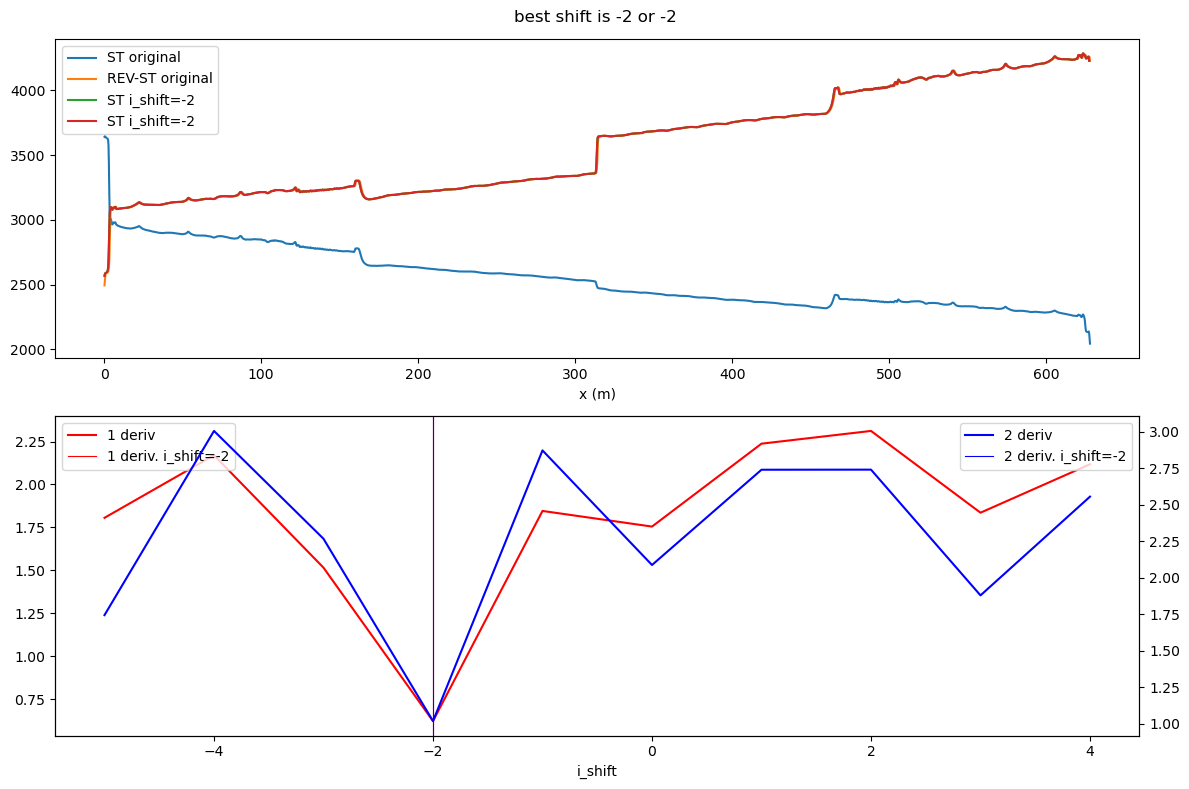

In [2]:
filepath = ''

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds_.sel(x=slice(0, 628.2))  # only calibrate parts of the fiber


sections = {
    'probe1Temperature': [slice(130., 158.)],  # temp isolator
    }
ds.sections = sections

suggested_shift = suggest_cable_shift_double_ended(
    ds,
    np.arange(-5, 5),
    plot_result=True,
    figsize=(12,8))

ds_restored = shift_double_ended(ds, suggested_shift[0])

print(ds.x, 3*'\n', ds_restored.x)

matching_sections = [
    (slice(130., 158.), slice(470.5, 498.75), False)
]
sections = {
    'probe1Temperature': [slice(130., 158.), slice(470., 500.)]
    }
ds_.sections = sections
st_var, resid = ds.variance_stokes(st_label='st')
ast_var, _ = ds.variance_stokes(st_label='ast')
rst_var, _ = ds.variance_stokes(st_label='rst')
rast_var, _ = ds.variance_stokes(st_label='rast')

ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    trans_att=[314.25],
    matching_sections=matching_sections,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds_.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')


# 0. DTS massaging

In [5]:
"""
Here, we will do something different. Instead of just using the mean signal for the SVD inversion. We will
do the SVD 6 times (3 measurements x 2 sides of fiber) - i.e. will remove the linear fit 6 different times
and do the whole workflow 6 different times. This should allow us to determine some levels of uncertainty.
Particularly in the trend removing piece of the equation.
""";

In [6]:
top_trend = 182 #optical distance (m), This is what we think the start of the long term signal is.
bottom_trend = 312.5 #optical distance (m), This is the bottom of the trend just above the warm bottom anomaly..
start_of_borehole = 162 #optical distance (m), Top of the borehole.

In [67]:
all_mes = []

for i in range(3):
    all_mes.append(ds.isel(time=i)['tmpw'])
    all_mes.append(ds.isel(time=i)['tmpw'][::-1].assign_coords(x= ds.isel(time=0).x))


In [9]:
#Parameters

tmax = 2023
tmin = 1023
zmax = bottom_trend - top_trend#150
dTdz = 0.02
nz = len(f0.sel(x=slice(top_trend,bottom_trend)))
nt = 99
alpha = 46
accumulation = 0

years = np.arange(tmin, tmax -1,1)

In [72]:
""" 
Do the looping here

Now we have all the measured borehole temps, forward and back for a total of 6 measurements of the profile.
And we have done the linear fitting and removal on each of those
""";
anomaly_list = []
x_intercept = []
y_slope = []

start_here = 0   # 0 is the start of the top of the trend for the removal of the longterm + geoflux
all_qgeos = []

for i in all_mes:

    m,b = np.polyfit(i.sel(x=slice(top_trend+start_here,bottom_trend)).x, 
                     i.sel(x=slice(top_trend+start_here,bottom_trend)), 1)

    Q_geo = m *2.5*1e3
    print(Q_geo)
    print(b)


    y  = m*i.sel(x=slice(top_trend,bottom_trend)).x + b
    anomaly = i.sel(x=slice(top_trend,bottom_trend)) - y
    
    y_slope.append(y)
    x_intercept.append(x)
    anomaly_list.append(anomaly)
    all_qgeos.append(Q_geo)

43.33164415708842
-33.948074618315566
43.12266379312744
-33.92996733300524
43.38599259585573
-33.75093764621424
43.14519569360329
-33.720860292913784
43.74704508671222
-32.91046959124269
43.45142781989607
-32.88427171172385


<IPython.core.display.Javascript object>


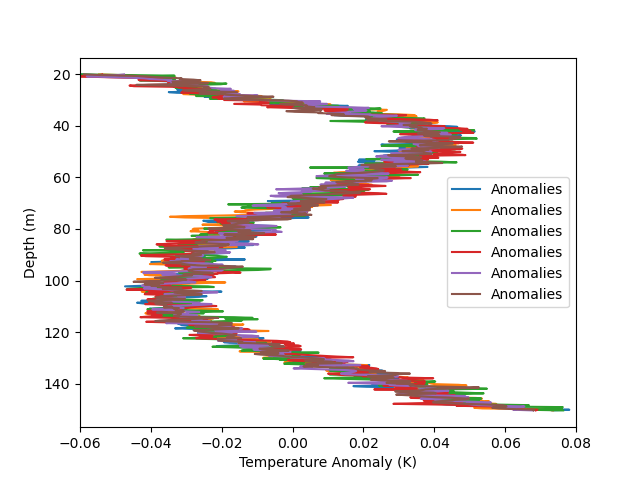

In [78]:
fig, ax = plt.subplots()

ax.plot( np.asarray(anomaly_list).T, ds.sel(x=slice(top_trend,bottom_trend)).x - start_of_borehole, label = 'Anomalies')


ax.set_xlabel('Temperature Anomaly (K)')
ax.set_ylabel('Depth (m)')


ax.invert_yaxis()
ax.set_xlim([-.06,0.08])
plt.legend()
plt.show()

# 2.0 Now, set up the forward model of borehole temps

In [93]:
from heat import *

import numpy as np

#Parameters

tmax = 2023
tmin = 1923
zmax = bottom_trend - top_trend#150
dTdz = 0.02
nz = len(ds.sel(x=slice(top_trend,bottom_trend)).x)
nt = 99
alpha = 35
accumulation = 0

t_surf = np.eye(nt)

A = np.zeros((nt+1,nz+1))

for i in range(nt): #this was for i in range(nt)
    this_t_surf = t_surf[i,:]
#     if i == 20: this_t_surf = 10*this_t_surf
    U,t,z = heat(this_t_surf,
         tmax = tmax,
         tmin = tmin,
         zmax = zmax,
         dTdz = dTdz,
         nz = nz,
         nt = nt,
         alpha = alpha,
         accumulation = accumulation)
    now = U[:,-1]
    A[i,:] = now
A = A.T
#     print(z.shape)
#     heat_plot(t, t_surf, 0, 1000, z, U)

In [96]:
nz

513

<IPython.core.display.Javascript object>


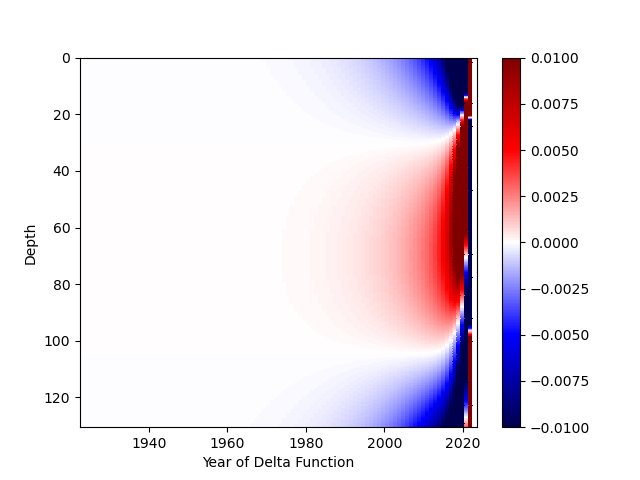

In [95]:
from scipy.signal import detrend
plt.subplots()
vm=0.01
c=plt.pcolor(t,z,detrend(A,axis=0),vmin=-vm,vmax=vm,cmap='seismic')
# c=plt.pcolor(t,z,A,vmin=-vm,vmax=vm,cmap='seismic')
plt.colorbar(c)
plt.ylim([zmax,0])
plt.xlabel('Year of Delta Function')
plt.ylabel('Depth')
plt.show()

# 3.0 Set up the inverse problem

## 3.1 The G matrix is the forward modeled borehole temps

<IPython.core.display.Javascript object>


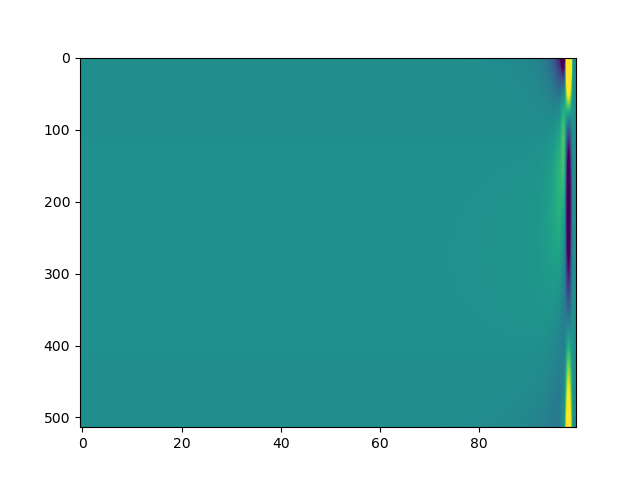

In [98]:
G_matrix = detrend(A,axis=0)

fig, ax = plt.subplots()
ax.imshow(G_matrix, aspect = 'auto', vmin=-.1, vmax=.1)
plt.show()

G_copy = G_matrix

## 3.2 Singular value threshold, plot the singular values

<IPython.core.display.Javascript object>


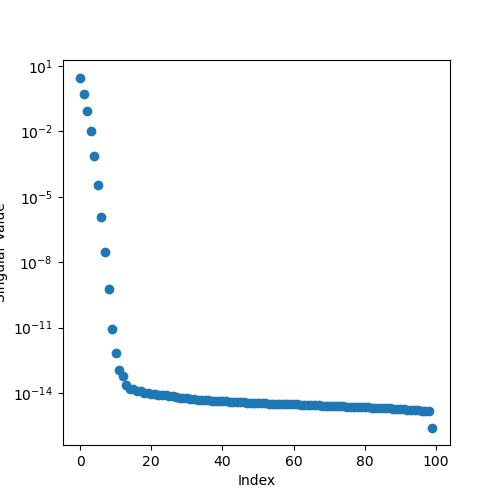

In [99]:
#Singular value decomposition
u, s, v_T = np.linalg.svd(G_copy, full_matrices=True)


#Plotting the singular values
fig,ax = plt.subplots(figsize=[5,5])
plt.scatter(np.arange(0,len(s)),s)
ax.set_xlabel('Index')
ax.set_ylabel('Singular Value')
ax.set_yscale('log')
#ax.set_xlim([0,10])
# print(s)
#fig.savefig('singular_values.eps')
plt.show()

## 3.3 Apply the thresholding

In [141]:


p = 3 #Applying the thresholding
u_p = u[:,:p]
s_p = np.diag(s[:p])
vh_p = v_T.T[:,:p]

# print('U_p =\n', u_p)
# print('S_p =\n',s_p)
# print('V_p =\n',vh_p)

## 3.4 Find the generalized G matrix and inverse G matrix

In [142]:
#Now finding the generalized G matrix

g_gen = u_p @ s_p @ vh_p.T
# print('G = \n', g_gen)

#And the inverse Gen G matrix

u_p_transpose = u_p.T
s_p_inv = np.linalg.inv(s_p)

g_inv = vh_p @ s_p_inv @ u_p_transpose

# print('G^-g = \n', g_inv)

# 5.0 Inversion and model estimates done here.

## 5.1 Model estimates: temperature reconstruction

<IPython.core.display.Javascript object>


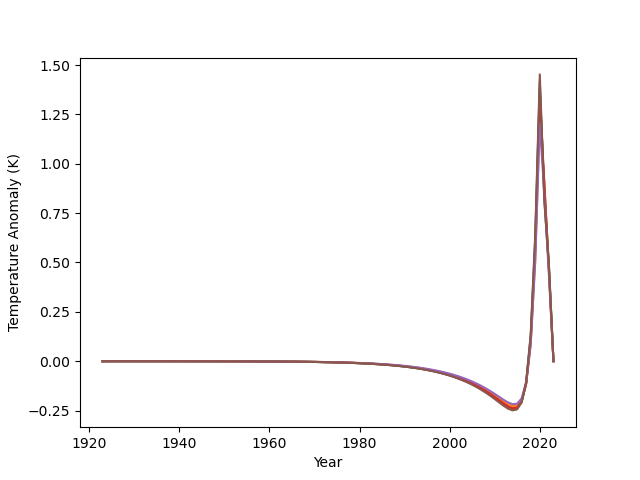

Text(0.5, 0, 'Year')

In [143]:
#model estimates
#m_est = g_inv @ anomaly.values
m_est = g_inv[:,:-1] @ np.asarray(anomaly_list).T

# m_est = g_inv[:,:-1] @ mean_tot.sel(x=slice(start_of_borehole,bottom_trend)).values

fig,ax = plt.subplots()
ax.plot(t,m_est)
ax.set_ylabel('Temperature Anomaly (K)')
ax.set_xlabel('Year')

## 5.2 Predicted data

<IPython.core.display.Javascript object>


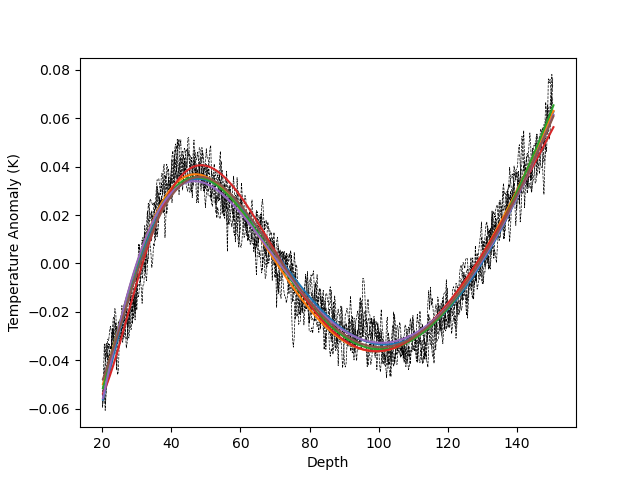

Text(0.5, 0, 'Depth')

In [131]:
#Predicted data
d_predicted = G_copy @ m_est

fig,ax = plt.subplots()

ax.plot(ds.sel(x=slice(top_trend,bottom_trend)).x - start_of_borehole, np.asarray(anomaly_list).T, 
        label='Actual Data', 
        color='Black', 
        ls='--',
        lw=.5)
ax.plot(z+20,d_predicted, label='Predicted Data')
ax.set_ylabel('Temperature Anomaly (K)')
ax.set_xlabel('Depth')